In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys

In [2]:
data = pd.read_csv('city_hotel.csv')

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Selected numerical and categorical variables
numerical_vars = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 
    'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
    'total_of_special_requests'
]
categorical_vars = [
    'arrival_date_month', 'meal', 'market_segment',
    'distribution_channel', 'reserved_room_type', 'deposit_type',
    'customer_type', 'reservation_status'
]

# Extracting the selected variables
data_selected = data[numerical_vars + categorical_vars]

# Preprocessing: standardization for numerical and one-hot encoding for categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_vars),
        ('cat', OneHotEncoder(drop='first'), categorical_vars)])

# Applying the transformations
data_preprocessed = preprocessor.fit_transform(data_selected)

# Get feature names after one-hot encoding for categorical variables
ohe_categories = preprocessor.named_transformers_['cat'].categories_
new_ohe_features = [
    f"{col}_{val}" for col, vals in zip(categorical_vars, ohe_categories) for val in vals[1:]
]

# Combine the numerical and new one-hot encoded feature names
all_feature_names = numerical_vars + new_ohe_features

# Convert the processed data into a dataframe
data_processed_df = pd.DataFrame(data_preprocessed, columns=all_feature_names)

data_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53399 entries, 0 to 53398
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       53399 non-null  float64
 1   stays_in_weekend_nights         53399 non-null  float64
 2   stays_in_week_nights            53399 non-null  float64
 3   adults                          53399 non-null  float64
 4   children                        53399 non-null  float64
 5   babies                          53399 non-null  float64
 6   previous_cancellations          53399 non-null  float64
 7   previous_bookings_not_canceled  53399 non-null  float64
 8   booking_changes                 53399 non-null  float64
 9   days_in_waiting_list            53399 non-null  float64
 10  adr                             53399 non-null  float64
 11  required_car_parking_spaces     53399 non-null  float64
 12  total_of_special_requests       

# Dimensionality Reduction

In [4]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3)
pca.fit(data_processed_df)
PCA_ds = pd.DataFrame(pca.transform(data_processed_df), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T


,count,mean,std,min,25%,50%,75%,max
col1,53399.0,-2.879346e-14,1.397791,-4.836488,-0.766757,-0.085669,0.628901,8.164983
col2,53399.0,-2.330788e-15,1.206580,-5.643590,-0.632831,0.016160,0.672881,6.939814
col3,53399.0,9.809865e-15,1.113774,-1.934447,-0.676656,-0.183938,0.409200,8.959152


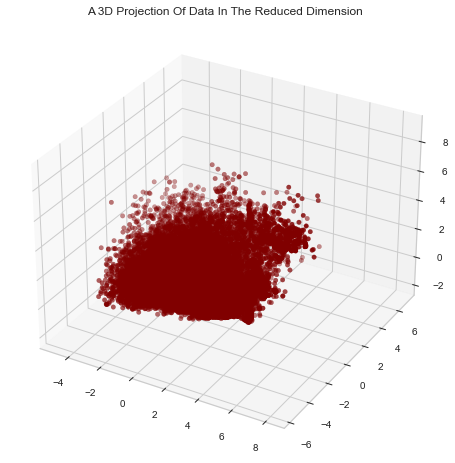

In [5]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Clustering

Elbow Method to determine the number of clusters to be formed:


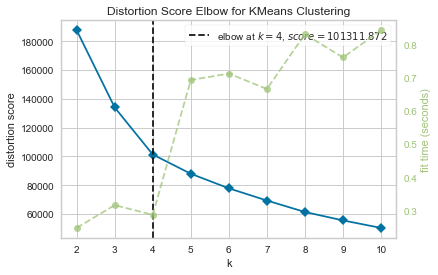

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [7]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

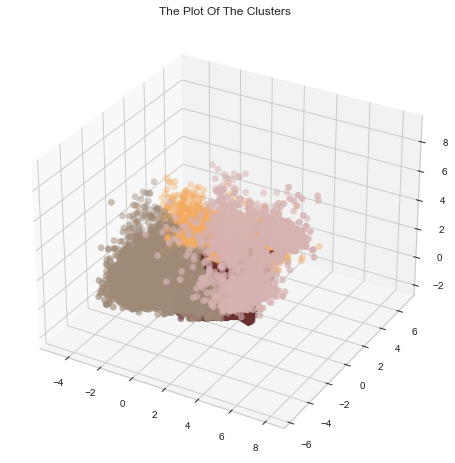

In [9]:
#Plotting the clusters
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

# Model Evaluation

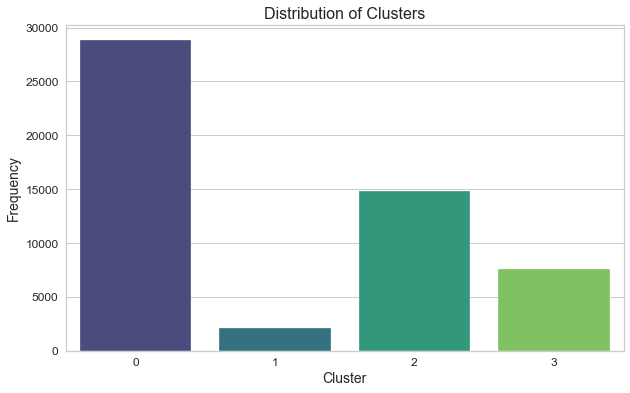

In [13]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Count the frequency of each cluster
cluster_count = data['Clusters'].value_counts()

# Create a bar plot for the clusters
sns.barplot(x=cluster_count.index, y=cluster_count.values, palette="viridis")

# Adding titles and labels
plt.title('Distribution of Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

# Profiling The Clusters

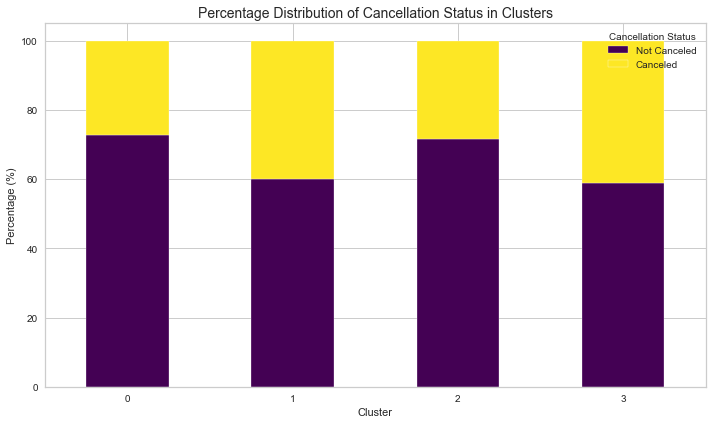

In [33]:
import matplotlib.pyplot as plt

# Grouping by 'Clusters' and 'is_canceled', and calculating the percentage within each cluster
cluster_cancellation_percentage = (data.groupby(['Clusters', 'is_canceled']).size() / data.groupby('Clusters').size()) * 100
cluster_cancellation_percentage = cluster_cancellation_percentage.unstack().fillna(0)

# Creating a stacked bar plot
ax = cluster_cancellation_percentage.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6), rot=0)

# Adding labels and title
ax.set_title('Percentage Distribution of Cancellation Status in Clusters', fontsize=14)
ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage (%)')
ax.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'], loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


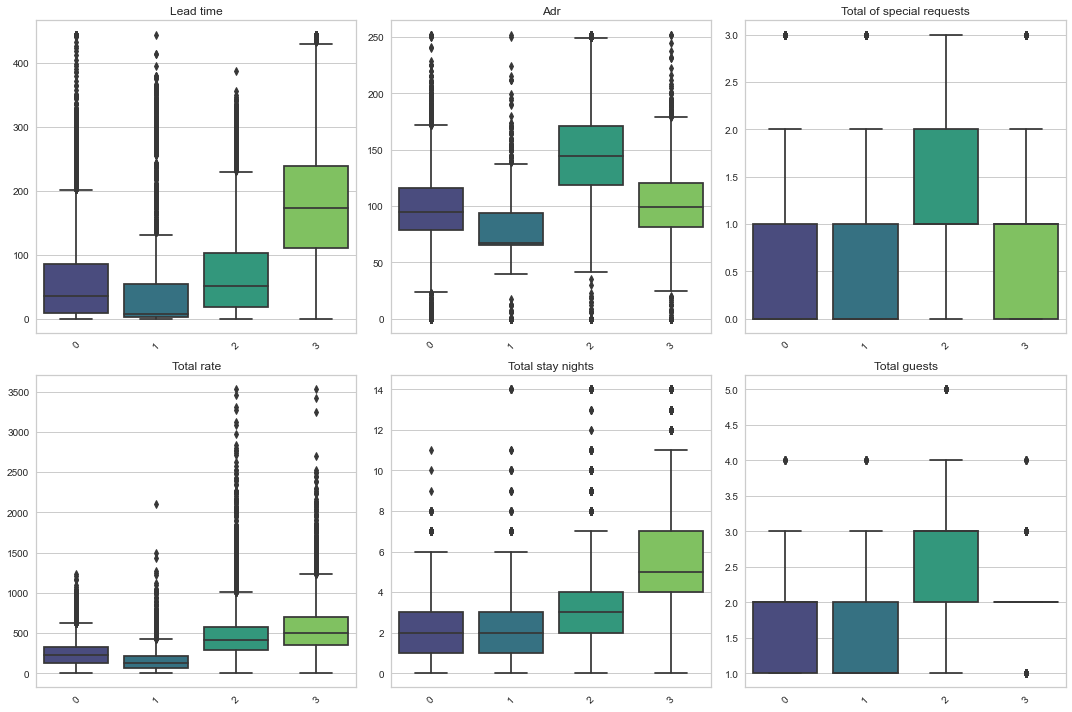

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the selected numerical features
numerical_features = ['lead_time', 'adr','total_of_special_requests', 'total_rate', 'total_stay_nights',
        'total_guests']

# Determine the layout for the subplots
num_features = len(numerical_features)
num_cols = 3  # Define the number of columns for the layout
num_rows = -(-num_features // num_cols)  # Calculate the number of rows needed, round up

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten the 2D array of axes into 1D

# Loop through the numerical features and create box plots
for i, feature in enumerate(numerical_features):
    sns.boxplot(ax=axes[i], x='Clusters', y=feature, data=data, palette='viridis')
    axes[i].set_title(feature.capitalize().replace('_', ' '))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [38]:
data_cluster_0 = data[data['Clusters'] == 0]
data_cluster_1 = data[data['Clusters'] == 1]
data_cluster_2 = data[data['Clusters'] == 2]
data_cluster_3 = data[data['Clusters'] == 3]

In [49]:
data_cluster_0.describe().median()

is_canceled                          0.358596
lead_time                           59.198518
arrival_date_year                 2016.089484
arrival_date_week_number            25.399192
arrival_date_day_of_month           15.834125
stays_in_weekend_nights              0.736415
stays_in_week_nights                 1.932349
adults                               1.863867
children                             0.007578
babies                               0.000000
is_repeated_guest                    0.003833
previous_cancellations               0.000000
previous_bookings_not_canceled       0.000295
booking_changes                      0.104623
agent                               19.581541
days_in_waiting_list                 0.135076
adr                                 95.889725
required_car_parking_spaces          0.000000
total_of_special_requests            0.516664
total_rate                         238.576488
total_stay_nights                    2.279221
total_guests                      

In [52]:
data_cluster_1.describe().median()


is_canceled                          0.444835
lead_time                           55.566022
arrival_date_year                 2015.940306
arrival_date_week_number            29.653056
arrival_date_day_of_month           15.859599
stays_in_weekend_nights              0.677019
stays_in_week_nights                 1.487345
adults                               1.190544
children                             0.013849
babies                               0.000000
is_repeated_guest                    0.819484
previous_cancellations               0.779131
previous_bookings_not_canceled       1.407614
booking_changes                      0.113181
agent                               11.664756
days_in_waiting_list                 0.302770
adr                                 69.974214
required_car_parking_spaces          0.056829
total_of_special_requests            0.755120
total_rate                         177.458804
total_stay_nights                    2.107450
total_guests                      

In [53]:
data_cluster_2.describe().median()


is_canceled                          0.368033
lead_time                           65.688801
arrival_date_year                 2016.190463
arrival_date_week_number            27.554308
arrival_date_day_of_month           15.866097
stays_in_weekend_nights              0.941186
stays_in_week_nights                 2.138173
adults                               2.000000
children                             0.553625
babies                               0.000000
is_repeated_guest                    0.004338
previous_cancellations               0.000000
previous_bookings_not_canceled       0.005481
booking_changes                      0.104715
agent                               10.832907
days_in_waiting_list                 0.000773
adr                                145.720340
required_car_parking_spaces          0.055384
total_of_special_requests            1.102731
total_rate                         441.843406
total_stay_nights                    3.079360
total_guests                      

In [54]:
data_cluster_3.describe().median()

is_canceled                          0.451194
lead_time                          175.772291
arrival_date_year                 2016.196476
arrival_date_week_number            28.618227
arrival_date_day_of_month           16.070358
stays_in_weekend_nights              1.785508
stays_in_week_nights                 3.949040
adults                               2.000000
children                             0.034521
babies                               0.000000
is_repeated_guest                    0.000592
previous_cancellations               0.000000
previous_bookings_not_canceled       0.001052
booking_changes                      0.182009
agent                               18.455944
days_in_waiting_list                 1.798724
adr                                100.913209
required_car_parking_spaces          0.000723
total_of_special_requests            0.928270
total_rate                         530.176037
total_stay_nights                    5.234548
total_guests                      